# Nye aviser

In [84]:
import dhlab.nbtext as nb
import dhlab.graph_networkx_louvain as gnl
import dhlab.nbtokenizer as tok
from dhlab.module_update import css, update, code_toggle

In [85]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
%matplotlib inline

In [86]:
def get_df(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def get_json(frases, mediatype='aviser', title='*'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'snippets':mediatype,
        'aggs':'year',
        
       'filter':['mediatype:{mt}'.format(mt=mediatype),'title:{title}'.format(title=title)],
        'searchType':'FULL_TEXT_SEARCH'
        #'filter':
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()
    return aggs

def get_data(frase, media='aviser', title='jazznytt'):
    import requests
    query = {
        'q':'"'+frase+'""',
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_data_and(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    print(querystring)
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media), 'title:{title}'.format(title=title)],
        #'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_df_pd(frase, media='bøker'):
    import pandas as pd
    return pd.DataFrame.from_dict(get_df(frase, media=media ), orient='index').sort_index()

In [87]:
def phrase_plots(phrase_sets, title='aftenposten', fra = 1960, til = 2020, step=5, rot=0, colours = ['r', 'b','g','y','m','c']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    df['bins'] = pd.cut(df.index, range(fra, til, step), precision = 0)
    df.groupby('bins').sum().plot(kind='bar', color=colours, figsize=(15,5), rot=rot)
    return

def phrase_plots_anno(phrase_sets, title='aftenposten', fra = 1960, til = 2020, rot=0, colours = ['r', 'b','g']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    #df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.plot(kind='bar', figsize=(15,5), rot=rot, color=colours)
    return

def graph_from_df(df, threshold = 100):
    edges =  []
    normalizer = {(x, y): df.stack()[(x,x)]*df.stack()[(y,y)] for (x,y) in df.stack().index}
    for (x, y) in df.stack().index:
        if x != y:
            if df.stack()[(x,y)] > threshold:
                edges.append([x,y,df.stack()[(x,y)]/normalizer[(x,y)]])
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

In [184]:
def super_search(title, number=50, page=0, mediatype='aviser', period = (18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/items", 
         params = { 
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'title:{title}'.format(title=title),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
             ],
             'page':page, 
             'size':number
         }
    )
    return r.json()

def get_df_level(frases, title='*', media='aviser', period = (18000101, 20401231),level='day:5'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':level,
        'filter':[
            'mediatype:{mt}'.format(mt=media),
            'title:{title}'.format(title=title),
            'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
        ]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/aggregations", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def phrase_plots_level(phrase_set, title='*', level='day', period=(20100101, 20301231)):
    df_all = [nb.frame(get_df_level(f, title = title, level = level, period = period), ', '.join(f)) for f in phrase_set]
    df = pd.concat(df_all, sort=False, axis=1)
    df.index = df.index.astype(int)
    df = df.sort_index()
    return df

In [82]:
def term_urn_search(term, number=50, page=0, mediatype='aviser', period=(18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    #print(period)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/search", 
         params = { 
             'q':term,
             'sort':'date,desc',
            
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1] )
             ],
             'page':page, 
             'size':number,
             'random':'true'
         }
    )
    res = r.json()
    tot = res['totalElements']
    if tot > 0:
        result = res['_embedded']['mediaTypeResults'][0]['result']['_embedded']['items']
        urns = [r['metadata']['identifiers']['urn'] for r in result]
    else:
        urns = []
    return tot, urns

In [27]:
def get_konks(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
        'fragments': n,
        'fragSize':window
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    results = []
    try:
        for x in res['contentFragments']:
            urn = x['pageid']
            hit = x['text']
            splits = hit.split('<em>')
            s2 = splits[1].split('</em>')
            before = splits[0]
            word = s2[0]
            after = s2[1]
            results.append({'urn': urn, 'before': before, 'word':word, 'after':after})
    except:
        True
    return results

In [32]:
def get_all_konks(term, urns):
    konks = []
    for u in urns:
        konks += get_konks(u, term)
    return konks

Estimer antallet av et ord i aviser

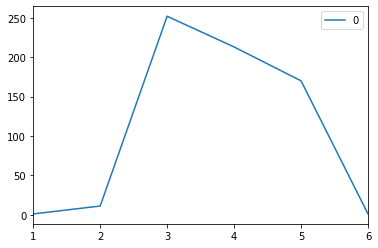

In [176]:
df = nb.frame(get_df_level(["corona", "korona", 'krone'], period=(20190520, 20200520 ), level='month'))
df.index = df.index.astype(int)
df = df.sort_index()
df.plot()

In [205]:
dfs = phrase_plots_level([["corona", "korona"], ['karantene'],['vaksine', 'vaksiner']], period=(20200201, 20200228 ), level='day')

In [206]:
dfs

,"corona, korona",karantene,"vaksine, vaksiner"
1,6.0,8,NaN
2,NaN,1,NaN
3,NaN,12,2.0
4,NaN,7,6.0
5,NaN,7,13.0
6,NaN,15,1.0
7,1.0,12,NaN
8,1.0,3,NaN
9,NaN,1,NaN
10,NaN,5,NaN


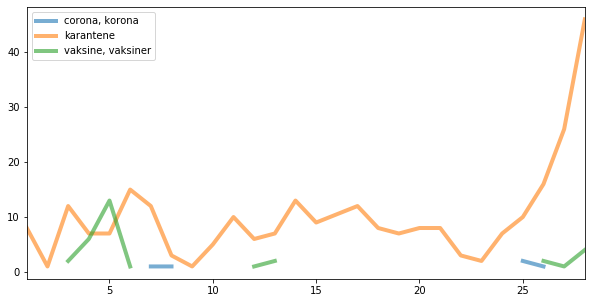

In [207]:
dfs.plot(figsize=(10,5), lw=4, alpha=.6)

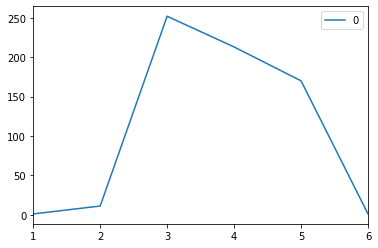

In [201]:
df.plot()

In [77]:
term_urn_search('likestilling', period=('19600101', '19601231'))

('19600101', '19601231')


(1611,
 ['URN:NBN:no-nb_digavis_dagbladet_null_null_19601102_92_256_2',
  'URN:NBN:no-nb_digavis_bergensarbeiderblad_null_null_19600615_34_136_1',
  'URN:NBN:no-nb_digavis_adresseavisen_null_null_19601025_194_249_1',
  'URN:NBN:no-nb_digavis_svalbardposten_null_null_19600102_12_6_1',
  'URN:NBN:no-nb_digavis_dagbladet_null_null_19600308_92_57_1',
  'URN:NBN:no-nb_digavis_grimstadadressetiden_null_null_19600901_105_99_1',
  'URN:NBN:no-nb_digavis_ranablad_null_null_19600825_59_197_1',
  'URN:NBN:no-nb_digavis_nordlandsposten_null_null_19600123_98_19_1',
  'URN:NBN:no-nb_digavis_dagbladet_null_null_19601111_92_264_1',
  'URN:NBN:no-nb_digavis_tromso_null_null_19600906_63_206_1',
  'URN:NBN:no-nb_digavis_glaamdalen_null_null_19600530_35_122_1',
  'URN:NBN:no-nb_digavis_nationen_null_null_19601123_43_274_1',
  'URN:NBN:no-nb_digavis_norgeskvinner_null_null_19601125_40_44_1',
  'URN:NBN:no-nb_digavis_lillehammertilskuer_null_null_19600523_117_118_1',
  'URN:NBN:no-nb_digavis_telemarkarbeide

In [76]:
tot

1611

In [81]:
totals = []
urn_tots = []
for i in range(1960, 1962):
    print(i)
    t, u = term_urn_search('likestilling', period=('{y}0101'.format(y=i), '{y}1231'.format(y=i)))
    totals.append(t)
    urn_tots.append(u)

1960
('19600101', '19601231')
1961
('19610101', '19611231')


In [83]:
totals

[1611, 1516]

In [80]:
term_urn_search('likestilling', period=('{y}0101'.format(y=i), '{y}1231'.format(y=i)))

('19600101', '19601231')


(1611,
 ['URN:NBN:no-nb_digavis_finnmarksposten_null_null_19600130_95_12_1',
  'URN:NBN:no-nb_digavis_varden_null_null_19601207_86_284_1',
  'URN:NBN:no-nb_digavis_dagbladet_null_null_19600223_92_45_1',
  'URN:NBN:no-nb_digavis_mossavis_null_null_19601026_86_249_1',
  'URN:NBN:no-nb_digavis_friheten_null_null_19601021_20_245_1',
  'URN:NBN:no-nb_digavis_aftenposten_null_null_19601004_101_458_1',
  'URN:NBN:no-nb_digavis_finnmarksposten_null_null_19600123_95_9_1',
  'URN:NBN:no-nb_digavis_adresseavisen_null_null_19600426_194_96_1',
  'URN:NBN:no-nb_digavis_osterdolen_null_null_19601115_60_266_1',
  'URN:NBN:no-nb_digavis_dagbladet_null_null_19601214_92_292_2',
  'URN:NBN:no-nb_digavis_stavangeraftenblad_null_null_19600629_68_148_1',
  'URN:NBN:no-nb_digavis_bergenstidende_null_null_19601124_93_275_1',
  'URN:NBN:no-nb_digavis_nationen_null_null_19600920_43_219_1',
  'URN:NBN:no-nb_digavis_varden_null_null_19600212_86_36_1',
  'URN:NBN:no-nb_digavis_nordlandsposten_null_null_19600504_98_

In [33]:
urn_hits = get_all_konks('likestilling', urns)

In [34]:
len(urn_hits)

81

In [35]:
len(urns)

50

In [38]:
tot * len(urn_hits)/len(urns)

59637.06

In [17]:
nb.unigram('likestilling',period=(1970, 1980)).sum()

0    13497
dtype: int64

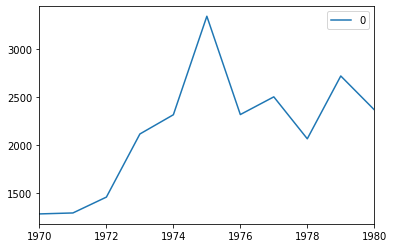

In [40]:
nb.unigram('likestilling', period=(1970, 1980), media='avis').plot()

In [ ]:
nb.unigram('likestilling', )